# Deep Convolutional Generative Adversarial Network (DCGAN) for Bored Apes

Would you buy a piece of digital art, a 631 x 631 pixels image, for \$200,000? This is actually the least money you can pay to purchase an NFT from the Bored Ape Yach Club collection (you can think of NFTs as a way to ensure uniqueness and ownership of digital art). It contains 10,000 digital images of cartoon apes. The project was launhed in April 2021 and has been one of the most successful NFT projects.

In this notebook, we use Deep Convolutional Generative Adversarial Networks (DCGAN) to generate new Bored Ape Yacht Club NFTs. Generative Adversarial Network, in general, is a Deep Learning Architecture wherein two agents, a Generator and Discriminator, compete against each other. The Generator attempts to create fake images that look like the real ones. The Discriminator's job is to discern between the real and fake images. Based on the Discriminator's feedback, the Generator attempts to improve. The training goes for many epochs. Ideally, until the Discriminator cannot tell the difference between the real and fake images. The process can be visualized as follows:

[ADD AN IMAGE]

In the sections below, we will dive into the process in more detail. The structure of the Notebook is following:
1. Preparing Data
2. Creating the Generator & Discriminator models
3. Defining the Loss & Optimization function
4. Describing the traning models
5. Evaluating results and images
6. Final Discussion

We also want to acknowledge that we reuse some code from Tensorflow's GAN Notebook, which you can find [here](https://www.tensorflow.org/tutorials/generative/dcgan).



### Import Libraries

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.5.0'

In [3]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


  Cloning https://github.com/tensorflow/docs to c:\users\nikita\appdata\local\temp\pip-req-build-2ts5ytnd


  Running command git clone -q https://github.com/tensorflow/docs 'C:\Users\Nikita\AppData\Local\Temp\pip-req-build-2ts5ytnd'
You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import pickle

from IPython import display

### Dataset

We downloaded the Bored Apes NFT dataset from [this Kaggle Dataset](https://www.kaggle.com/stanleyjzheng/bored-apes-yacht-club/version/2). One of the images were corrupt, so we manually removed it, leaving us with 9999 Bored Apes.

We processed the images by converting them from BRGA to RGBA image format, resizing them to 64x64, and saving them in a pickle file from which we can quickly reload the data. 

While we would love to generate 631x631 pixel size fake Bored Apes, our computational availability wouldn't allow that. Hence, we settled on 64x64 size which would speed up our training.

In [91]:
# run this only if the Pickle file isn't already created
import cv2

depth = 3
image_size_y = 64
image_size_x = 64

image_data = []

# for each image in the folder:
for image in glob.glob('dataset/*.jpg'):
    # read the image
    #img = cv2.imread(image, cv2.IMREAD_UNCHANGED)
    img = cv2.imread(image)
    # convert it from BGRA to RGBA for matplolib compatibility
    # https://www.bogotobogo.com/python/OpenCV_Python/python_opencv3_matplotlib_rgb_brg_image_load_display_save.php
    b,g,r= cv2.split(img)       # get b,g,r,a
    img = cv2.merge([r,g,b])     # switch it to rgba

    # resize to 64x64
    img = cv2.resize(img, dsize=(image_size_y, image_size_x), interpolation=cv2.INTER_AREA)
    image_data.append(img)

image_data = np.array(image_data, dtype='float32')
    
#dump the data into a pickle file
with open('bored_apes_64_3.pkl', 'wb') as file:
    dataset = image_data
    pickle.dump(dataset, file)
#image_data = np.array(image_data)   

In [122]:
#with open('apes3.npy', 'wb') as f:
   #np.save(f, image_data)

In [123]:
#with open('apes3.npy', 'rb') as f:
    #image_data = np.load(f)

In [15]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [119]:
file = open('bored_apes_64_3.pkl', 'rb')
image_data = pickle.load(file)
file.close()

In [124]:
# Define some constants
depth = 3
image_size_y = 64
image_size_x = 64
BUFFER_SIZE = 9999
BATCH_SIZE = 256

# reshape the dataset to (9999, 64, 64, 4)
train_images = image_data.reshape(len(image_data), image_size_x, image_size_y, depth).astype('float32')
# rescale the pixel values to [-1, 1]
train_images = (train_images - 127.5) / 127.5 
# convert to valid tensorflow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

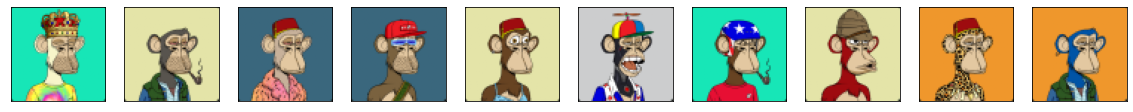

In [125]:
def plot_images(n, images):
    '''
    Plots n images from the dataset
    '''
    # turn the images from [-1, 1] to [0, 1]
    images = images*127.5 + 127.5
    images = images / 255.0

    plt.figure(figsize=(20, 10))
    
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
            
    plt.show()
    
plot_images(10, train_images)

Finally, after the image processing, our Bored Apes to 'excited' to stand in-between the Generator vs. Discriminator battle.

## Model Architecture

In this section, we will describe in-detail the architectures of Generator and Discriminator.

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

As mentioned above, the Generator's job is to create fake images that look like the real ones. It takes an array of random noise as input and then, using Convolutional and Upsampling layers, it creates an image. In particular, we use `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image of a desired size from a random noise. It takes a few layers to scale up to the desired size. 

We first scale up our random noise of size (100,) to the desired starting image size with a Dense layer. Next, we apply several blocks of Convolution&Upsampling -> BatchNormalization -> LeakyReLU. Convolutional layers is what helps the generator learn patterns and shapes to generate the apes. BatchNormalization normalizes the data by substracting the mean and dividing by the standard deviation of the batch. This simplifies speeds up the training and also prevent some activation functions, like ReLU from stopping the learning process. Finally, we apply the LeakyReLU activation function. This is what 'fires' the neurons and enables the training. We finish the model with a final Conv2DTranspose layer, which has 3 filters for the 3 color channels (RGB) and uses the tanh activation function. Tanh is a bounded function between -1 and 1. Using the function enables the model to learn the saturation and color spectrum of the images faster (Radford et al., 2016).

You may also notice that we set bias to False in `Conv2DTranspose` layers because BatchNormalization adds a bias term of its own, so we don't need to add another one in the `Conv2DTranspose` layer.

In [95]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8,512)))
    assert model.output_shape == (None, 8, 8, 512)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

Let's create an image with the yet untrained generator. As expected, it doesn't generate anything but random noise. But sit tight, as Generator's time is yet to come!

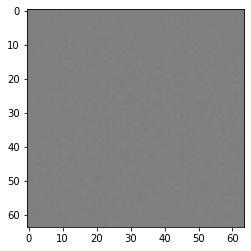

In [56]:
generator = make_generator_model()

# generator random noise
noise = tf.random.normal([1, 100])

# generate an image and set training to False to ensure no training happens in the process
generated_image = generator(noise, training=False)

# convert the pixel values from [-1, 1] to [0, 1] for matplotlib compatibility.
plt.imshow((generated_image[0, :, :, :]*127.5 + 127.5) / 255.0)

### The Discriminator

The discriminator is a CNN-based image classifier. Its task is to differentiate the real images vs. the fake ones. Since it's a CNN classification task, we decided to try and apply Transfer Learning from VGG16 to speed up the training and make a robust discriminator. The idea is that we take the first many layers of pre-trained VGG16 model which are trained to recognize various shapes and patterns. However, we exclude the 'top' part which correspond to dataset-specific patterns. Then, we add a few trainable layers on top of the base model so that our model can also specialize in our dataset. Finally, we have a single Dense layer with a sigmoid activaiton function & binary cross-entropy loss function because we are facing a binary classification problem. The usage of Transfer Learning is purely experimental and we are excited to see how it works out. 

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [20]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same',
                                     input_shape=[64, 64, 4]))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPool2D(pool_size=(2, 2), padding="same"))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPool2D(pool_size=(2, 2), padding="same"))
    model.add(layers.Dropout(0.1))

    model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPool2D(pool_size=(2, 2), padding="same"))
    model.add(layers.Dropout(0.05))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [70]:
discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator(generated_image)
print (decision)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 32768)            

In [96]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

def make_discriminator_model():
    #extract features from pretrained model mobile-net
    base_model = VGG16(weights='imagenet',
                            include_top=False, input_shape=(64, 64, 3))
    base_model.trainable = False
    x = base_model.output
    x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)
    
    model = Model(inputs=base_model.input, outputs=x)

    return model

In [97]:
discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator(generated_image)
print (decision)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0   

## Loss functions and optimizers

In this section, we define loss functions and optimizers.


We will base our loss functions of cross-entropy. Cross-entropy is a loss function that calculates how 'suprising' it was to observe the predictions given the true distribution. For example, if we pass in 2 images (Real, Fake), their labels would be (1, 0). Now, let's say our Discriminator gives the following probabilities of images being real: (0.89, 0.1). This is the formula for binary cross-entropy: $H = -\frac{1}{N} \sum_{i=1}^N t_i \log{(p_i)} + (1 - t_i) \log{(1-p(y_i))}$, where t is the truth value (1 or 0), $p_i$ is the sigmoid probability, and $N$ is the number of points. Let's apply it to find the cross-entropy in our example:

1. $H_1 = 1*\log{(0.89)} + 0*\log{(0.11)} = -0.16812$
2. $H_2 = 1*\log{(0.1)} + 0*\log{(0.9)}= -3.322$
3. $H = -\frac{1}{N} * (H_1 + H_2) = -\frac{1}{2} * (-0.16812 + -3.322) = 1.75$

You can see that if we would have predicted the Real image to be real with P=1, then our Cross-Entropy would be 0. And this is what we are aiming for: minimizing cross-entropy. However, with GANs things a just a bit different. Let's see how.

In [5]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

Discriminator's job is to distinguish real from the fake images. Since we are not using labels in our training process, we have to modify our loss function a bit. We will compare the discriminator's predictions on real images to an array of 1s, and predictions on fake images to an array of 0s. We will then combine the two to return the total_loss.

In [99]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss should quantify how well it can trick the discriminator. It wants the Discriminator to classify Fake images as Real (probability of P(real) = 1). Therefore, we want to compute the cross-entropy for the generator's loss by comparing Discriminator's predictions on fake images to an array of 1s

In [100]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are also different because we are training the two networks separately. We will use the Adam algorithm, which is essentially a version of Gradient Descent. We are *descending* because we want to *minimize* the loss function.

In [101]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
In case our training process gets interrupted, we define checkpoints that would save the model throughout the process.

In [102]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop

Now that we have our dataset, models, and loss & optimizers, it's time to see how they come together in the training process.

In [103]:
# define constants. We will train the model for 50 epochs
EPOCHS = 50
noise_dim = 100

seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

The training process is as following:\
*for each epoch*:
1. Initialize the random input noise
2. Use this noise to generate fake images using Generator
3. Classify the images as real/fake using Discriminator
4. Calculate the loss functions for both Generator & Discriminator
5. Find the gradients
6. Apply the gradients to minimize loss functions, thus improving the performance

In [104]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    # 1. Initialize the random input noise
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # 2. generate fake images
        generated_images = generator(noise, training=True)
    
        # 3. get predicitons of Discriminator on the Real and Fake images
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # 4. find the loss value for the generator and discriminator using loss functions above
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # 5. find the gradients 
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # 6. apply the gradients to optimize the performance
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [105]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

## Train the model
Finally, we call the `train()` method above to train the Generator and Discriminator simultaniously. To improve the results and prevent our laptop from melting a hole in the desk, we will train our model on an AWS EC2 instance. You can find the training file here: https://github.com/nikita-kotsehub/DCGAN_training_package

To download the pre-processed data, follow these steps inside the repo:
1. Install the Google Drive package to easily download files from Google Drive: `pip install gdown`
2. Download the [data](https://drive.google.com/file/d/1DwQkMDHC1R9E2heYqFPjBo6B443iNSP3/view?usp=sharing) using file id: `wget --id 1DwQkMDHC1R9E2heYqFPjBo6B443iNSP3`

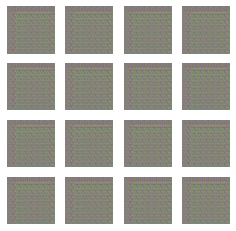

In [107]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [108]:
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Finally, after 50 epochs and 30 hours of training, we are going to load our model and evalute its performance.

In [117]:
from tensorflow.keras.models import load_model
model = load_model('generator_1')

## a GIF



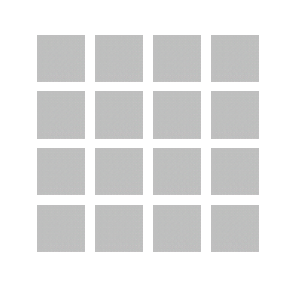

In [15]:
import tensorflow_docs.vis.embed as embed
anim_file = 'dcgan.gif'
embed.embed_file(anim_file)

## Evaluation

In this section, we will evaluate the GAN's performance via quantitative and qualitative methods.

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow((generated_image[0, :, :, :]*127.5 + 127.5) / 255.0)

## Discussion


This tutorial has shown the complete code necessary to write and train a GAN. As a next step, you might like to experiment with a different dataset, for example the Large-scale Celeb Faces Attributes (CelebA) dataset [available on Kaggle](https://www.kaggle.com/jessicali9530/celeba-dataset). To learn more about GANs see the [NIPS 2016 Tutorial: Generative Adversarial Networks](https://arxiv.org/abs/1701.00160).


### References